In [ ]:
!sudo apt-get install -y language-pack-id
!sudo apt-get install -y language-pack-de-base
!sudo apt install -y cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-lang-european texlive-lang-all

In [ ]:
!git clone https://github.com/andriygav/ExpertLearning.git
!mv ExpertLearning/code/dump ./dump

In [ ]:
!pip install mixturelib
!pip install matplotlib==2.0.2

In [23]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm.notebook import tqdm

import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import pickle

from sklearn.model_selection import ParameterGrid

In [2]:
from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModelLinear, EachModel
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

from mixturelib.regularizers import RegularizeModel

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [15]:
import locale

locale.setlocale(locale.LC_ALL, 'de_DE.utf8')

plt.rcParams['axes.formatter.use_locale'] = True

In [4]:
plt.rcParams["font.family"] = 'DejaVu Sans'

plt.rcParams['text.latex.unicode'] = True

plt.rcParams['text.usetex'] = True

plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}']

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
with open('./dump/experiment.pkl', 'rb') as f:
    experiment_dict = pickle.load(f)

In [7]:
def get_parabola(w, w0=None, y_min=-1, y_max=4):
    y0 = np.linspace(y_min, y_max, 10000)
    x1 = 0.5*(-1*(-w[0]*y0 - w[2])+np.sqrt((-w[0]*y0-w[2])**2-4*(-w[1]*y0**2 - w[3]*y0-w[4])))
    x2 = 0.5*(-1*(-w[0]*y0 - w[2])-np.sqrt((-w[0]*y0-w[2])**2-4*(-w[1]*y0**2 - w[3]*y0-w[4])))

    y_all = np.hstack([y0[::-1], y0])
    x_all = np.hstack([x1[::-1], x2])
    

    return x_all, y_all

In [8]:
def f(beta, gamma):
    key = json.dumps({'beta': beta, 'gamma': gamma})
    
    w_real = experiment_dict['results'][key]['w_real']
    w_pred = experiment_dict['results'][key]['w_pred']
    
    return sum([((w_real[k] - w_pred[k])**2).sum() for k in range(experiment_dict['K'])])

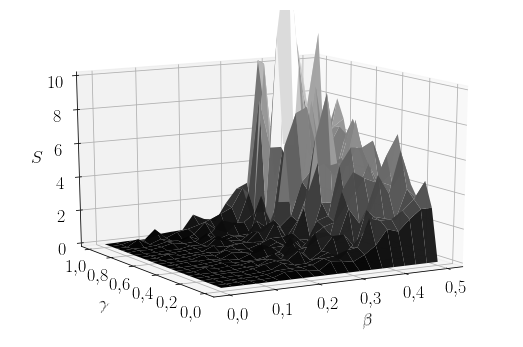

In [20]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

BETAS, GAMMAS = np.meshgrid(experiment_dict['betas'], experiment_dict['gammas'])

scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = f(BETAS[i][j], GAMMAS[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, GAMMAS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 15)
ax.set_ylabel(r'$\gamma$', labelpad= 15)
ax.set_zlabel(r'$S$')

ax.set_xticklabels(['$0{,}0$', '$0{,}1$', '$0{,}2$', '$0{,}3$', '$0{,}4$', '$0{,}5$'])
ax.set_yticklabels(['$0{,}0$', '$0{,}2$', '$0{,}4$', '$0{,}6$', '$0{,}8$', '$1{,}0$'])

ax.set_zlim((0,10))

ax.view_init(15, -120)

plt.savefig('3dplot.pdf', bbox_inches='tight')
plt.show()

In [21]:
betas = [0.001, 0.21052631578947367, 0.39473684210526316]
gammas = [0.0001, 0.15789473684210525, 0.5263157894736842]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


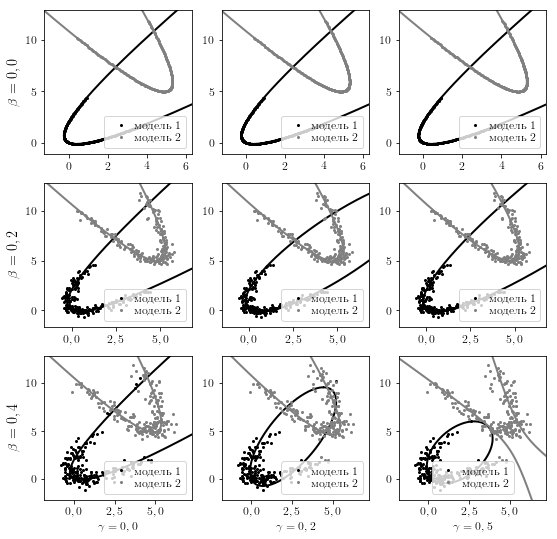

In [25]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################
colors = ['black', 'grey', 'red', 'yellow', 'blue']

fig = plt.figure();
gs = gridspec.GridSpec(len(betas), len(gammas))

ax = []
for i in range(len(betas)*len(gammas)):
    ax.append(fig.add_subplot(gs[i]))
    
for i in range(3):
    ax[3*i].annotate(r'$\beta={}$'.format(str(np.round(betas[i], 1)).replace('.', ',')), 
                     xy=(0, 0.5), 
                     xytext=(-ax[3*i].yaxis.labelpad - 4, 0),
                     xycoords=ax[3*i].yaxis.label, textcoords='offset points',
                     size='large', ha='center', va='center', rotation=90)
    
for i in range(3):
    ax[3*2+i].set_title(r'$\gamma={}$'.format(str(np.round(gammas[i], 1)).replace('.', ',')), 
                        y=-0.25)


        
for t, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        key = json.dumps({'beta': beta, 'gamma': gamma})
        
        x = experiment_dict['results'][key]['x']
        y = experiment_dict['results'][key]['y']
        w_pred = experiment_dict['results'][key]['w_pred']
        model = experiment_dict['results'][key]['model']

        X = np.vstack([x*y, y**2, x, y, np.ones_like(x)]).T
        Y = x**2

        X_tr = torch.FloatTensor(X)
        idx = np.argmax(model.predict(X_tr)[1], axis = 1)

        ax[len(gammas)*t+j].set_xlim((np.min(x)-1, np.max(x)+1))
        ax[len(gammas)*t+j].set_ylim((np.min(y)-1, np.max(y)+1))

        for k in range(experiment_dict['K']):
            _ = ax[len(gammas)*t+j].plot(
                *get_parabola(w_pred[k], y_min=np.min(y)-10, 
                              y_max=np.max(y)+10), color = colors[k])


        for i in range(len(model.ListOfModels)):
            _ = ax[len(gammas)*t+j].plot(
                x[idx == i], y[idx == i], '.', color = colors[i], 
                label = 'модель '+str(i+1))

        ax[len(gammas)*t+j].legend(loc='best')
        
plt.savefig('beta_gamma.pdf', bbox_inches='tight')
plt.show()

## Глаза

In [26]:
color = ['black', 'gray', 'black', 'black', 'black']

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
image = Image.open('dump/1.tiff')

mask_1 = Image.open('dump/1_mask_3.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

In [29]:
x = np.array(np.where(np.array(mask_1) > 0)[1], dtype = np.float)
y = np.array(mask_1.size[0]-np.where(np.array(mask_1) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y, random_state = 0)

x = x[:200]
y = y[:200]

X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(torch.Size([200, 3]), torch.Size([200, 1]))

In [30]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.predict(X_tr)[1], axis = 1)
    
    return CIRCLE, idx

### Введение

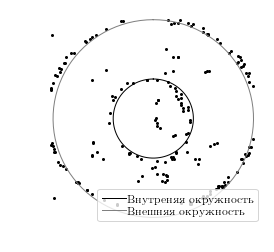

In [32]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color
    
k = 1
plt.plot(x, y, '.', color = color[0])
plt.axis('off')

CIRCLE = [[-0.15,-0.00,0.7],[-0.15,-0.00,1.75]]
leg = ['Внутреняя окружность', 'Внешняя окружность']
for i in range(2):
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)

    _ = plt.plot(x_plot, y_plot, '-', color = colors[i], label=leg[i])

plt.legend(loc='best')


plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('outline_image.pdf', bbox_inches='tight')

plt.show()

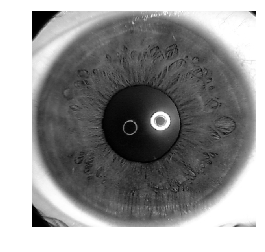

In [156]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

plt.imshow(image.convert("L"), cmap='gray')
plt.axis('off')


plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('real_image.pdf', bbox_inches='tight')

plt.show()

### Эксперимент с глазом

In [34]:
K = 2
n = 3

epoch = 10

In [99]:
%%time
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1.0}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=100)

model = MixtureEM(HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, 
                  device = device, model_type='sample')


List_of_step_Not_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Not_Prior.append(extract_picture(model))

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 4.6 s, sys: 34 ms, total: 4.64 s
Wall time: 6.11 s


In [148]:
%%time
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

LIST_A = [torch.Tensor([1e-3, 1e-3, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

HypPar = {'beta': 1.0}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEM(HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, 
                  device = device, model_type='sample')


List_of_step_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior.append(extract_picture(model))


  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 34.5 s, sys: 105 ms, total: 34.6 s
Wall time: 35.4 s


In [149]:
%%time
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

LIST_A = [torch.Tensor([1e-1, 1e-1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.0], [0.0], [1]]), torch.Tensor([[0.0], [0.0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

HypPar = {'beta': 1.0, 'alpha': 1e-3}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)
Rg = RegularizeModel(ListOfModels = LoM, device = device)
model = MixtureEM(HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, 
                  ListOfRegularizeModel = [Rg], device = device, model_type='sample')

List_of_step_Prior_Regular = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior_Regular.append(extract_picture(model))

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 32.6 s, sys: 106 ms, total: 32.7 s
Wall time: 32.6 s


In [150]:
List_of_answers_comparing = [List_of_step_Not_Prior[-1], List_of_step_Prior[-1], List_of_step_Prior_Regular[-1]]
lang = 'ru'

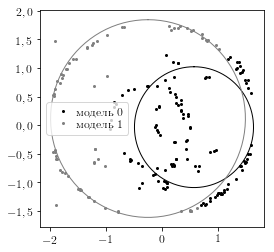

In [151]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color

CIRCLE, idx = List_of_answers_comparing[0]
for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'модель '+str(i))

    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)

    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])

plt.legend(loc='best')


plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('not_prior_real_example.pdf', bbox_inches='tight')

plt.show()

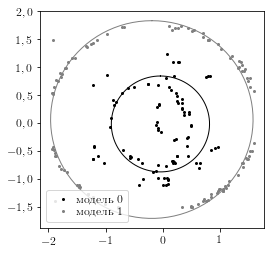

In [152]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color

CIRCLE, idx = List_of_answers_comparing[1]
for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'модель '+str(i))

    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)

    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])

plt.legend(loc='best')


plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('prior_real_example.pdf', bbox_inches='tight')

plt.show()

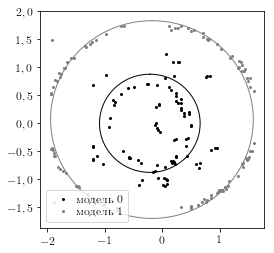

In [153]:
Text_size = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color

CIRCLE, idx = List_of_answers_comparing[2]
for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'модель '+str(i))

    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)

    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])

plt.legend(loc='best')


plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.savefig('prior_regular_real_example.pdf', bbox_inches='tight')

plt.show()

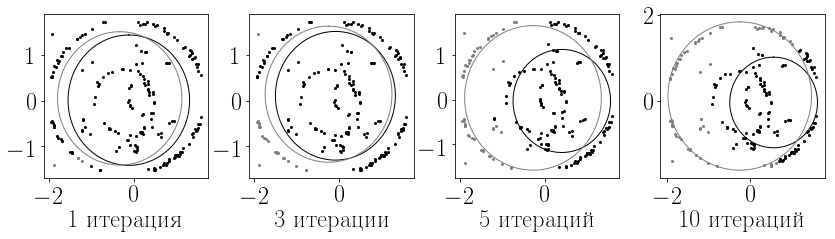

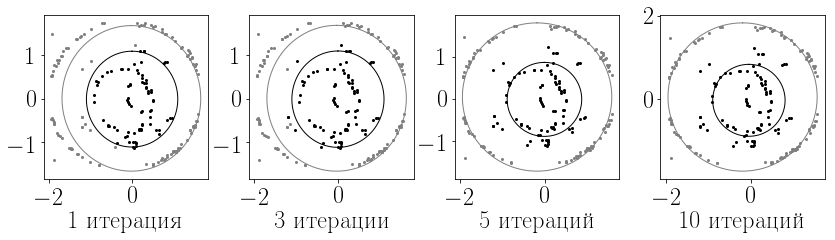

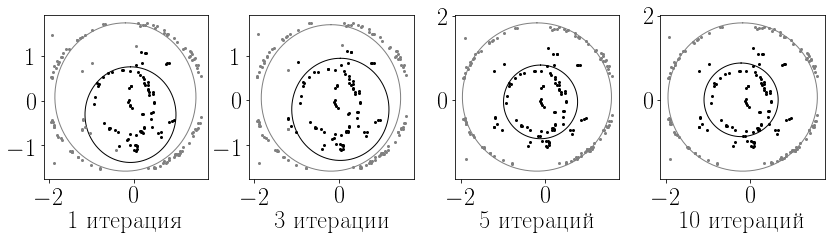

In [154]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (14.0, 3.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

epochs = [1, 2, 6, 9]

t = np.linspace(0, 2*np.pi, 100)

colors = color

if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Без задания априорного распределения', 'C заданием априорного распределения на модели', 'Регуляризация априорных распределений']  

if lang == 'eng':
    cols = [str(e) + ' epoch' for e in epochs]
elif lang == 'ru':
    cols = ['1 итерация', '3 итерации', '5 итераций', '10 итераций', '15 итераций', '25 итераций']


# -----------------1---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(epochs)):
    ax.append(fig.add_subplot(gs[k]))
    
for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)

List_of_step = [(List_of_step_Not_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])


plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('experiment_real_not_prior.pdf', bbox_inches='tight')
plt.show()    
    
# -----------------2---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('experiment_real_prior.pdf', bbox_inches='tight')
plt.show()

# -----------------3---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior_Regular[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('experiment_real_regular.pdf', bbox_inches='tight')
plt.show()